In [1]:
# We now to random sampling to generate empirical distributions, and see if it makes sense

# import relevant modules and files

import numpy as np
import pandas as pd

df_annotations = {}

for i in range(1, 23):
    df_annotations[i] = pd.read_csv(f"{i}permutationready.tsv", sep="\t")


In [7]:
annotations = ['3_prime_UTR_variant','5_prime_UTR_variant','NMD_transcript_variant','coding_sequence_variant','downstream_gene_variant','incomplete_terminal_codon_variant','intergenic_variant','intron_variant','mature_miRNA_variant','missense_variant','non_coding_transcript_exon_variant','non_coding_transcript_variant','splice_acceptor_variant','splice_donor_variant','splice_region_variant','start_lost','stop_gained','stop_lost','stop_retained_variant','synonymous_variant','upstream_gene_variant']
# do for all chromosomes
df_noheader = {}
np_df = {}
location_vec = {}
annotation_matrix = {}
a_matrix = {}

for i in range(1,23):
    df_noheader[i] = df_annotations[i].copy()
    np_df[i] = df_noheader[i].to_numpy()
    location_vec[i] = np_df[i][::,1]
    annotation_matrix[i] = np_df[i][::,2:]
    a_matrix[i] = annotation_matrix[i].transpose()

In [6]:
import time

In [9]:
# bootstrap with resampling

count_matrix = {}

tic = time.time()

for i in range(1,23):

    count_matrix[i] = np.zeros((21,10000))
    
    for j in range(0,10000):
        new_loc = np.random.permutation(location_vec[i])
        c_vec = np.matmul(a_matrix[i], new_loc)
        count_matrix[i][:,j] = c_vec
    
toc = time.time()
print("Time taken: {}".format(toc-tic))

# Time taken: 2905.0365023612976, compared to 655.4909727573395 with roll



Time taken: 2905.0365023612976


In [10]:
# save as dataframe

for i in range(1,23):
    pd.DataFrame(count_matrix[i]).to_csv(f"bootstrap10k_chrom{i}.tsv", sep="\t", index=False)

In [11]:
# calculate original number of sign SNPs in each annotation

original_number = {}

for i in range(1,23):
    original_number[i] = np.matmul(a_matrix[i],location_vec[i])


In [12]:
from collections import Counter

freq_matrix = {} # for all chromosomes

for i in range(1,23):
    
    freq_matrix[i] = {}

    for j in range(0,21):
            freq_matrix[i][j] = Counter(count_matrix[i][j,::]) # count all permutations for one annotation

In [13]:
# calculating enrichment
enrichment_matrix = np.zeros((22,21))

for i in range(0,22):
# each row is the count nr in the corresponding chromosome n-1 (so row 0 corresponds to chrom 1)
    for k in range(0,21): # k is the annotation nr
        for l in freq_matrix[i+1][k]: # l is number of sign SNP in annotation
            if l >= original_number[i+1][k]: # and original_number[i+1][k] != 0: 
                enrichment_matrix[i][k] = enrichment_matrix[i][k] + freq_matrix[i+1][k][l] # freq_matrix[i+1][k][l] 
                                                                              # is nr of counts of l sign SNP 
                                                                              # in annotation
                        
p_vals_e = enrichment_matrix/10000 #pvals for enrichment


In [15]:
# Calculating depletion

depletion_matrix = np.zeros((22,21))

for i in range(0,22):
# each row is the count nr in the corresponding chromosome n-1 (so row 0 corresponds to chrom 1)
    for k in range(0,21): # k is the annotation nr
        for l in freq_matrix[i+1][k]: # l is number of sign SNP in annotation
            if l <= original_number[i+1][k]: # and original_number[i+1][k] != 0: 
                depletion_matrix[i][k] = depletion_matrix[i][k] + freq_matrix[i+1][k][l] # freq_matrix[i+1][k][l] 
                                                                              # is nr of counts of l sign SNP 
                                                                              # in annotation
                        
p_vals_d = depletion_matrix/10000 #pvals for depletion

In [16]:
# load package
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,MaxNLocator

In [17]:
a = list(mpl.rcParams.keys())
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

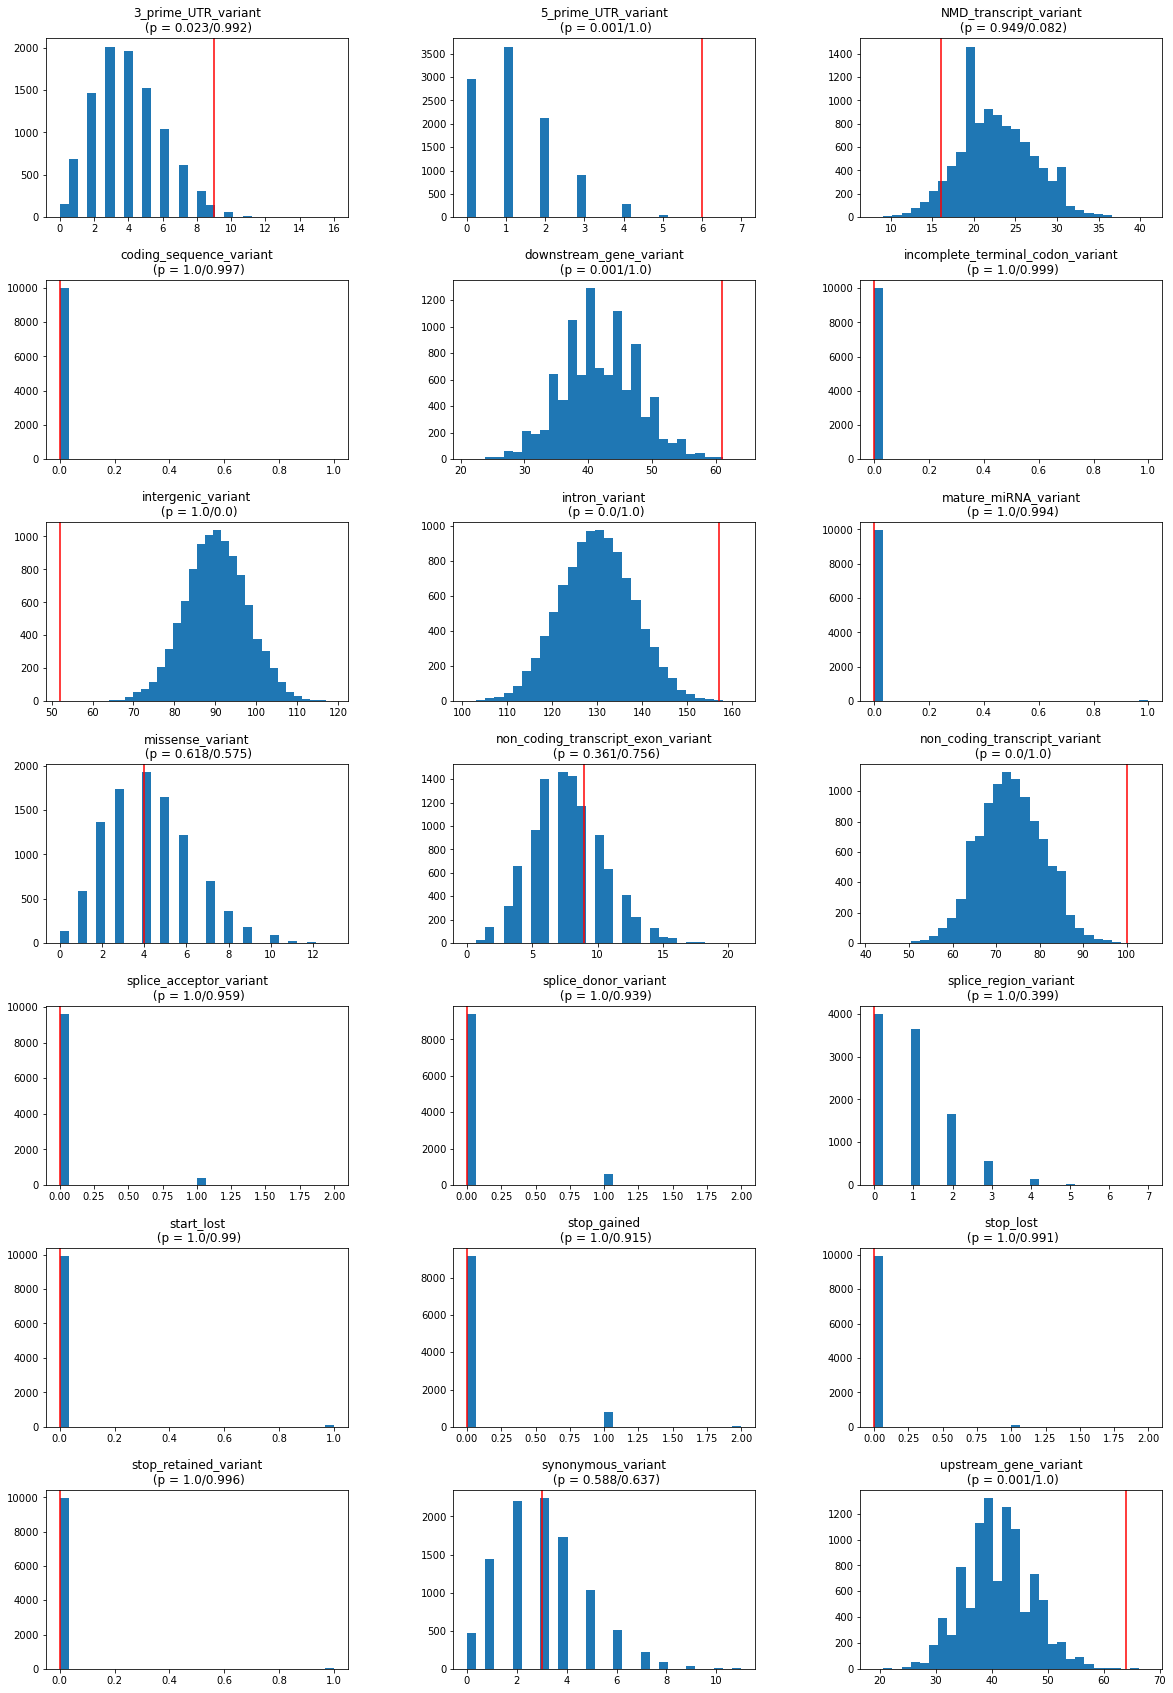

In [18]:
fig,axs = plt.subplots(nrows=7,ncols=3,figsize=(20,30),gridspec_kw={'wspace':0.35,'hspace':0.35})
i = 1 # chromosome
l = -1
for j in range(0,7):
    for k in range(0,3):
        l = l+1
        axs[j,k].hist(count_matrix[i][l,::], bins=30)
        axs[j,k].set_title(str(annotations[l]) + "\n" + " (p = " + str(np.around(p_vals_e[i-1][l], decimals=3)) + "/" + str(np.around(p_vals_d[i-1][l], decimals=3)) + ")")
        axs[j,k].axvline(x=original_number[i][l], color='r', label= 'observed number' )

#fig.text(0.5, 0.04, 'common xlabel', ha='center', va='center', fontsize = 20)
#fig.text(0.06, 0.5, 'common ylabel', ha='center', va='center', rotation='vertical', fontsize=20)
#for ax in axs.flat:
   # ax.set(xlabel='Number of significant SNPs', ylabel='Frequency')

plt.savefig("chrom_" +str(i)+ "_10k")